# LIBOR Market Model

In [4]:
import pandas as pd 
import numpy as np 
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev 
from scipy.stats import norm 
from scipy import optimize as opt
import datetime

### Non-technical derivation of the model

I try to give a more intuitive explanation of the model, rather than derive the model via only mathematics:

The LIBOR forward rates denoted with $L(t, T_i, T_{i+1})$ are linked to zero-coupon bond prices $B(t, T)$ which can be seen by an easy replication example. 

Assume I invest at time $t$ in $B(t, T_1)$ and financing this by issuing a number of $k$ zero-coupon bonds $B(t, T_2)$ such that $B(t,T_1) = k B(t, T_2)$ with $T_1 < T_2$. At maturity, both bonds have a value of $1$, thus I obtain $1$ at $T_1$ and have to pay $k$ at $T_2$. According to the no-arbitrage principle, I should be able to invest $1$ at $T_1$ for a specific LIBOR forward rate $L(t, T_1, T_2)(T_2 - T_1)$ between $T_1$ and $T_2$ such that $1 + L(t, T_1, T_2)(T_2 - T_1) = k$ at $T_2$. Rearranging the equation and using $k = \frac{B(t,T_1)}{B(t, T_2)}$ from the equation above, I get the following general relationship:

\begin{equation}
L(t, T_i, T_{i+1}) = \frac{B(t, T_i) - B(t, T_{i+1})}{\delta B(t, T_{i+1})}
\end{equation}

with $\delta = T_{i+1} - T_{i}$.

Hence, I have the starting point. From here, the derivation depends on the numeraire used. Brace et al. (1997) apply the money-market account defined by $\beta(t) = e^{\int_{0}^{t} r(u)du}$ as the risk-neutral measure. Thus, Brace et al. (1997) rely on the continuously compounded spot rate $r$ in their derivation and therefore mix discrete tenor with continuous tenor quantities. Because one would like to avoid modeling $r$ within the model, Musiela and Rutkowski (1997) changed the numeraire to a $T_{i+1}$-forward measure.

Here, the zero-coupon bond $B(t,T_{i+1})$ that corresponds to the maturity of the forward rate $T_{i+1}$ is taken as the numeraire. Applying the numeraire $B(t,T_{i+1})$, one observe that the LIBOR forward rate $L(t, T_{i}, T_{i+1})$ is a martingale under the $T_{i+1}$-forward measure of the form

\begin{equation}
dL(t, T_{i}, T_{i+1}) = \sigma_{i+1}(t) L(t, T_{i}, T_{i+1})dW^{i+1}(t)
\end{equation}

where $W^{i+1}(t)$ is an $n$-dimensional Brownian motion vector and $\sigma_{i+1}(t)$ is the volatility at time $t$ for the forward rate

However, each process for each LIBOR forward rate is now defined by a different numeraire, because there is just one $B(t,T_{i+1})$ that corresponds to the maturity $T_{i+1}$ of each forward rate. Thus, the dynamics are also needed for the $T_{k}$-forward measure, where the maturity of the forward rate $T_{i+1}$ does not correspond to $T_{k}$ such that $T_{k} < T_{i+1}$ or $T_{k} > T_{i+1}$. For $T_{k} < T_{i+1}$ the dynamic is given by

\begin{equation}
\frac{dL(t, T_{i}, T_{i+1})}{L(t, T_{i}, T_{i+1})} = \sum_{j = k}^{i} \frac{\delta_i L(t, T_{j-1}, T_j)\sigma_{i+1}(t)\sigma_{j+1}(t)}{1 + \delta_i L(t, T_{j}, T_{j+1})}dt + \sigma_{i+1}(t)dW^{k}(t)
\end{equation}

By applying Itos Lemma, the process for the LIBOR forward rates to price a security with maturity $T_k$, which can be used in the Monte Carlo Simulation, is obtained: 

\begin{equation}
\begin{split}
L(t + dt, T_i, T_{i+1}) = L(t, T_i, T_{i+1}) \exp \left[ m(t) dt + \sigma(T_{i+1} - t) \sqrt{dt} W_t \right] \\
m(t) = \sum_{j= k}^{i} \frac{\delta L(t, T_{j}, T_{j + 1}) \sigma (T_{i+1} - t) \sigma(T_{j+1} - t)}{1 + \delta L(t, T_{j}, T_{j+1})} - \frac{1}{2}  \sigma(T_{i+1} - t) ^2 
\end{split}
\end{equation}

## Step 1 - Calibration - Forward Rate Volatilities

There are a few options to calibrate the model. I will introduce two of them

For missing data or interpolation in general a cubic function is used

In [5]:
def f_cubic(x: list, x_points: list, y_points: list) -> list:
    """
    x = datapoints for which y-values are needed
    x_points = datapoints (x-axis)
    y_points = datapoints (y-axis)
    """
    
    # Interpolate data 
    data_int = splrep(x_points, y_points)
    # Get y-values for other x-values
    new_y = splev(x, data_int)
    
    return new_y

### Calibration (based on Veronesi 2010, Hull 2017,  Hull & White 2000)

The starting point of the calibration procedure are the at-the-money implied volatilities $\sigma_f$ from the Black formula which can be observed in the market.  The Black formula for a caplet $C$ at time $t$ is given by:

\begin{equation}
\begin{split}
C(t) = X \delta B(0, T_{i+1}) [L(0, T_i, T_{i+1}) \mathcal{N}(d1) - r_K\mathcal{N}(d2)]\\
d1 = \frac{1}{\sigma_f \sqrt{T_i}} log\left(\frac{L(t, T_i, T_{i+1})}{r_K}\right) + \frac{1}{2}\sigma_f \sqrt{T_i} \\ 
d2 = d1 - \sigma_f \sqrt{T_i}
\end{split}
\end{equation}

where $X$ describes the notional value, $r_K$ the strike rate, $\delta = T_{i+1} - T_{i}$ and $\mathcal{N}$ normal distribution.


The first step is to extract forward volatilites of caplets from the quoted volatilities in order to get a unique volatility that corresponds to a single caplet. The bootstrap methodology is used: 

1. Calculate the price of each cap from quoted volatilities
2. The first cap consists of only one caplet, so the quoted volatility is equal to the forward volatility of the caplet
3. We use the forward volatility of the caplet from step 2 to price all caplets (except the last one) that consists of the next cap 
4. Calculate the difference between the cap price at step 1 and step 3
5. Find the associated implied volatility from the price difference at step 4
6. Restart step 3 to 5 until all volatilities have been calculated


Next, the volatilities for the forward rates in the Monte-Carlo simulation are needed. The volatility of forward rates depends on the time to maturity and the associated function of volatility is constant. Therefore, Veronesi (2010) and Hull & White (2000) showed that the spot rate $L(T_i, T_i, T_{i+1})$ is lognormally distributed with variance $var(L(T_i, T_i, T_{i+1})) = \delta\sigma_{Fwd, i}^2 + \delta\sigma_{Fwd, i-1}^2 + \dotso + \delta\sigma_{Fwd, 1}^2$. One can show that the variance $var(L(T_i, T_i, T_{i+1}))$ can be expressed as $\sigma_{caplet}(T_{i+1}-t)^2(T_{i}-t)$. Thus, with the inital condition that the first caplet forward rate volatility is equal to the first forward rate volatility, the other forward rate volatilities $\sigma_{Fwd}$ are calculated recursively with: 

\begin{equation}
\sigma_{Fwd, i} = \sqrt{\frac{1}{\delta}\left(\sigma_{caplet}(T_{i+1}-t)(T_i - t) - \sum_{j=1}^{i-1} \delta \sigma_{Fwd, j}\right) } \; \; \; \; \; \; \; \;.
\end{equation}

Now apply the procedure to the following data:

Hint: LIBOR USD

In [6]:
Implied_vola_reuters = [0, 27.41147, 27.55104, 27.87439, 28.48852, 28.66229, 28.67498, 28.63304, 28.67856, 29.24294, 
                        30.34450, 31.74778]
mat_reuters = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
strike_reuters = [0, 0.0498807, 0.0498258, 0.0493196, 0.048067, 0.0472109, 0.0464609, 0.0457168, 0.0449407, 
                  0.0441991, 0.0434854, 0.0428533]

fwd_reuters = [0.04751, 0.049275, 0.046802, 0.04064]
df_reuters = [0.9885517, 0.9525363, 0.9121222, 0.8782411]
df_mat_reuters = [0.25, 1, 2, 3]

Interpolate missing data with cubic function

In [7]:
fwd_reuters = f_cubic(mat_reuters, df_mat_reuters, fwd_reuters)
df_reuters = f_cubic(mat_reuters, df_mat_reuters, df_reuters)

Complete data:

In [8]:
data = pd.DataFrame({"Maturity": mat_reuters, "Strike": strike_reuters, "Forward Rates": fwd_reuters, "Discount Factors": df_reuters,
             "Implied Vol": Implied_vola_reuters})
data

,Maturity,Strike,Forward Rates,Discount Factors,Implied Vol
0,0.25,0.000000,0.047510,0.988552,0.00000
1,0.50,0.049881,0.048505,0.975930,27.41147
2,0.75,0.049826,0.049083,0.963937,27.55104
3,1.00,0.049320,0.049275,0.952536,27.87439
4,1.25,0.048067,0.049112,0.941691,28.48852
5,1.50,0.047211,0.048624,0.931365,28.66229
6,1.75,0.046461,0.047844,0.921521,28.67498
7,2.00,0.045717,0.046802,0.912122,28.63304
8,2.25,0.044941,0.045529,0.903132,28.67856
9,2.50,0.044199,0.044058,0.894512,29.24294


Black formula implemented

In [9]:
def black_caplet(F_0, K, expiry, vol, df, notional, delta):
    

    """
    F_0 = Libor Rate zum Zeitpunkt 0 
    K = Strike 
    expiry = Expiry of Cap f(0, 1, 1.25) -> expiry = 1 
    vol = implied volatility
    df = discount factor 
    notional = notional value
    delta = zcb_expiry - expiry
    
    """
    
    option_value = 0
    
    # if expiry today
    if expiry * vol == 0.0:
        option_value = max(F_0 - K, 0.0)
    else:
        d1 = d1Black(F_0 = F_0 , K = K, expiry = expiry ,vol = vol)
        d2 = d2Black(F_0 = F_0 , K = K, expiry = expiry ,vol = vol)
        option_value =  df*(F_0 * norm.cdf(d1) - K *norm.cdf(d2))
        
    return notional  * delta * option_value

def d1Black(F_0 , K, expiry , vol):
    d_plus = (np.log(F_0 / K) + 0.5 * vol**2 * expiry)/ (vol * np.sqrt(expiry))
    return d_plus

def d2Black(F_0 , K, expiry , vol):
    d_minus = (d1Black(F_0 = F_0 , K = K, expiry = expiry ,vol = vol ) - vol * np.sqrt(expiry))
    return d_minus

Bootstrap Methodology:

In [10]:
# Step 1 
def cap_prices(fwd_reuters: list, strike_reuters: list, mat_reuters: list, Implied_vola_reuters: list, 
               df_reuters: list, notional: float = 100, delta: float = 0.25, scale: float = 100) -> list:

    """
    step 1 of bootstrap methodology: calculate price of each cap implied by data from Reuters
    """
    
    impl_prices = []
    cap_maturity = 1

    # two for loops as implied vola and strike are changing for each cap, while forward rate, maturity, discount factor 
    # is changing for each caplet  
    for j in range(1, len(mat_reuters)):
        cap_maturity += 1
        impl = [0]
        for i in range(1, cap_maturity):
            impl.append(black_caplet(fwd_reuters[i], strike_reuters[j], mat_reuters[i-1], Implied_vola_reuters[j]/scale, 
                                            df_reuters[i], notional, delta))
        # sum to get price of cap 
        impl_prices.append(np.sum(impl))
        
    return [0] + impl_prices

In [11]:
# functions to find vol at step 4

def diff_caplet(impl_vol: float, fwd: float, K: float, maturity: float, df: float, notional: float, delta: float, 
                comp_val: float) -> float:
    """
    calculate difference between caplet price and price implied by Black formula -> difference should be minimized
    """
    
    # get caplet price with Black formula
    caplet_val = black_caplet(fwd, K, maturity, impl_vol, df, notional, delta)
    
    return ((caplet_val - comp_val)**2) *1000

def get_impl_vol(fwd: float, K: float, maturity: float, df: float, notional: float, delta: float, comp_val: float) -> float:
    
    """
    calculate implied volatility which minimizes the difference 
    """
    
    opt_results = scipy.optimize.minimize(diff_caplet,x0=[0.1], method='Nelder-Mead', bounds = [(0,1)], tol=0.0000001,
                                            args = (fwd, K, maturity, df, notional, delta, comp_val)).x
    
    return opt_results
    

In [12]:
def calc_price(fwd_rates_vola: list, strike_k: list, maturity: list, vol_fwd: list, df_vola: list, 
               x: int, notional: float = 100, delta: float = 0.25):
    """
    calculate cap prices at step 3! with quoted vol 
    
    Use i-1 for maturity and vol_fwd:as described in Bootstrap Methodology we use the volatility of the cap before (see step 3) 
                                      and we always use T_i instead of T_i+1 for Black formula (see Black formula)
    
    
    fwd_rates_vola = list with all forward rates 
    strike_k = list with strike rates 
    maturity = years fraction 
    vol_fwd = volatility of forward rates in %
    df_vola = discount factors 
    x = number of caplets in a cap 
    
    """
    price_cap = 0
    for i in range(1, x):
        price_cap += black_caplet(fwd_rates_vola[i], strike_k, maturity[i-1], vol_fwd[i-1], df_vola[i], notional, delta)
        
    return price_cap

In [13]:
def calc_forward_vola(impl_price: list, fwd_rates_vola: list, strike_rates: list, maturity: list, first_impl_vola: float, 
                      df_vola: list,  notional: float = 100, delta: float = 0.25):
    
    """
    Bootstrap Methodology except of step 1 
    """
    # step 2 
    vol_fwd = [first_impl_vola] 
    
    for i in range(2, len(maturity)):
        # price cap with volatility of the last cap - step 3
        price_cap = calc_price(fwd_rates_vola, strike_rates[i], maturity, vol_fwd, df_vola, i) 
        # calculate differences in prices - step 4
        diff_price = impl_price[i-1] - price_cap
        # get implied volatility of difference - step 5 
        impl_vol_t = get_impl_vol(fwd_rates_vola[i], strike_rates[i], maturity[i-1], df_vola[i], notional, delta, diff_price)
        vol_fwd.append(impl_vol_t[0])
        
    return [0] + vol_fwd

Apply to data:

In [14]:
impl_prices = cap_prices(fwd_reuters, strike_reuters, mat_reuters, Implied_vola_reuters, df_reuters)
fwd_vol_reuters = calc_forward_vola(impl_prices, fwd_reuters, strike_reuters, mat_reuters, Implied_vola_reuters[1]/100, df_reuters)

data["Cap Prices"] = impl_prices
data["Caplet Forward Rate Volatilities"] = fwd_vol_reuters

data

,Maturity,Strike,Forward Rates,Discount Factors,Implied Vol,Cap Prices,Caplet Forward Rate Volatilities
0,0.25,0.000000,0.047510,0.988552,0.00000,0.000000,0.000000
1,0.50,0.049881,0.048505,0.975930,27.41147,0.050154,0.274115
2,0.75,0.049826,0.049083,0.963937,27.55104,0.134815,0.000000
3,1.00,0.049320,0.049275,0.952536,27.87439,0.259351,0.196489
4,1.25,0.048067,0.049112,0.941691,28.48852,0.450015,0.125324
5,1.50,0.047211,0.048624,0.931365,28.66229,0.653197,0.238807
6,1.75,0.046461,0.047844,0.921521,28.67498,0.868595,0.240394
7,2.00,0.045717,0.046802,0.912122,28.63304,1.096314,0.238984
8,2.25,0.044941,0.045529,0.903132,28.67856,1.339637,0.237307
9,2.50,0.044199,0.044058,0.894512,29.24294,1.606294,0.260339


Now calculate forward rate volatilities:

In [15]:
def recursive_vola(maturity: pd.Series, cap_vol: pd.Series, delta: float = 0.25) -> np.array:
    
    """
    function calculates forward rates volatilities from cap volatilities
    
    maturity: maturity structure (e.g. 0.25, 0.5, 0.75, ...)
    cap_vol: caplet volatility for each mturity 
    delta: time length between maturities (e.g. here 0.25)
    """
    # arrays to store data
    size = len(cap_vol)
    fwd_vol = np.zeros(size)
    sum_rec = np.zeros(size)
    
    # fix for the first period
    fwd_vol[0] = cap_vol[0]
    sum_rec[0] = fwd_vol[0] ** 2 * delta
    
    # calculate recursively
    for i in range(1, size):
        adj_vol = cap_vol[i]**2 * maturity[i]
        sum_sub = np.sum(sum_rec)
        
        # no neg. sqrt
        if adj_vol > sum_sub:
            fwd_vol[i] = np.sqrt(1/delta * (adj_vol - sum_sub))
            
        sum_rec[i] = fwd_vol[i] ** 2 * delta
        
    fwd_vol = np.append(fwd_vol, 0)
    
    return fwd_vol

In [16]:
vol_reuters = recursive_vola(mat_reuters, fwd_vol_reuters[1:])

data["Forward Rate Volatilities"] = vol_reuters

data

,Maturity,Strike,Forward Rates,Discount Factors,Implied Vol,Cap Prices,Caplet Forward Rate Volatilities,Forward Rate Volatilities
0,0.25,0.000000,0.047510,0.988552,0.00000,0.000000,0.000000,0.274115
1,0.50,0.049881,0.048505,0.975930,27.41147,0.050154,0.274115,0.000000
2,0.75,0.049826,0.049083,0.963937,27.55104,0.134815,0.000000,0.201704
3,1.00,0.049320,0.049275,0.952536,27.87439,0.259351,0.196489,0.000000
4,1.25,0.048067,0.049112,0.941691,28.48852,0.450015,0.125324,0.411486
5,1.50,0.047211,0.048624,0.931365,28.66229,0.653197,0.238807,0.248176
6,1.75,0.046461,0.047844,0.921521,28.67498,0.868595,0.240394,0.230342
7,2.00,0.045717,0.046802,0.912122,28.63304,1.096314,0.238984,0.225222
8,2.25,0.044941,0.045529,0.903132,28.67856,1.339637,0.237307,0.399338
9,2.50,0.044199,0.044058,0.894512,29.24294,1.606294,0.260339,0.548343


### Calibration 2 (Based on Rebonato, Brigo & Mercurio 2002)

The volatility still depend only on the time left to expiry. However, now the volatilities are calibrated to a function $\sigma_i(t) = \psi(T_{i-1} - t; a, b, c, d) := (a + b(T_{i-1} - t))e^{-c(T_{i-1} - t)} + d$. This function might not fit the volatility structure perfectly, therefore adjust the function with $k$ as $k = \frac{\sigma_{Market}}{\sqrt{\frac{1}{T_{i-1}} \int_{0}^{T_{i-1}} \psi(T_{i-1} - t; a, b, c, d)^2}}$.

Thus, calibrate parameters a,b,c,d via minimization between $\sigma_{Market}$ and $\psi(T_{i-1} - t; a, b, c, d)$. Adjust function with $k$ afterwards

Hint: There are also other functions with less/more parameters and advantage/disadvantages (see Brigo & Mercurio)

Continue with the data:

In [17]:
cap_vol = data["Implied Vol"][1:]/100
fwd_mat = data["Maturity"][1:]

In [18]:
def parametric(T, a, b, c, d):
    return ((a + b*T)*np.exp(-c*T) + d)**2

In [19]:
def calc_vola(lower, upper, a, b, c, d):
    return np.sqrt((1/upper) * scipy.integrate.quad(parametric, lower, upper, args = (a,b,c,d))[0])

In [20]:
def diff_sum(param, maturities, cap_vola, start):
    
    a = param[0]
    b = param[1]
    c = param[2]
    d = param[3]
    
    vola_parametric = []
    
    for mat in maturities:
        vola_parametric.append(calc_vola(start, mat, a, b, c, d))
    
    return np.sum((np.array(cap_vola) - np.array(vola_parametric))**2)

In [21]:
def constr(param):
        return param[0] + param[3]

def min_diff(param, maturities, cap_vola, start=0):
    
    bounds = tuple([(None, None), (None, None), (0, None), (0, None)])
    
    constr_all= [{'type': 'ineq', 'fun': constr}]
    
    opt_results = scipy.optimize.minimize(diff_sum,x0=param, method='SLSQP', bounds = bounds, constraints=constr_all,
                                            args = (maturities, cap_vola, start)).x
    
    a = opt_results[0]
    b = opt_results[1]
    c = opt_results[2]
    d = opt_results[3]
    
    eps = diff_sum([a,b,c,d], maturities, cap_vola, start)
    
    return a, b, c, d, eps

In [22]:
param = min_diff(param=[0,0,0,0], maturities=fwd_mat, cap_vola=cap_vol)

In [23]:
vola_parametric = []
start = 0
    
for mat in fwd_mat:
    vola_parametric.append(calc_vola(start, mat, param[0], param[1], param[2], param[3]))

In [24]:
df_vol = pd.DataFrame({"Cap_Vol": cap_vol, "Calibrated_Vol": vola_parametric})
df_vol

,Cap_Vol,Calibrated_Vol
1,0.274115,0.271404
2,0.275510,0.274976
3,0.278744,0.278499
4,0.284885,0.281972
5,0.286623,0.285394
6,0.286750,0.288767
7,0.286330,0.292088
8,0.286786,0.295358
9,0.292429,0.298577
10,0.303445,0.301744


Good fit, but not perfect. Therefore adjustment with $k$

In [25]:
def k(cap_vol, cal_vol):
    return cap_vol/cal_vol

In [26]:
k_adj = k(cap_vol, np.array(df_vol["Calibrated_Vol"]))

In [27]:
df_vol["Calibrated_adj"] = k_adj * df_vol["Calibrated_Vol"]
df_vol

,Cap_Vol,Calibrated_Vol,Calibrated_adj
1,0.274115,0.271404,0.274115
2,0.275510,0.274976,0.275510
3,0.278744,0.278499,0.278744
4,0.284885,0.281972,0.284885
5,0.286623,0.285394,0.286623
6,0.286750,0.288767,0.286750
7,0.286330,0.292088,0.286330
8,0.286786,0.295358,0.286786
9,0.292429,0.298577,0.292429
10,0.303445,0.301744,0.303445


# Single LIBOR Market Model

In [28]:
def simulate_forward_rates(fwd: np.array, fwd_vol_begin: np.array, maturity: np.array, steps: int, 
                           driftMatrix: np.matrix, delta: float, start = None, stop = None, store: bool =False):
    
    """
    function for simulating  a single path of forward rates
    
    fwd = forward rates 
    fwd_vol_begin = volatilities of forward rates 
    maturity = in years fraction
    steps = number of steps 
    store = true, then store values for each step 
    start, stop = specify which rows should be included 
    """

    # Relevant values 
    fwd = fwd[start:stop]
    
    # dt 
    dt_fix = 1/steps
    
    store_fwd = pd.DataFrame({"0": fwd})
    
    for i in range(1, steps):
        
        # sum of steps 
        dt = i/steps
        
        # move volatilities in time 
        fwd_vol = f_cubic(maturity - dt, maturity, fwd_vol_begin)
        # get cov matrix for drift 
        cov_vol = np.multiply.outer(fwd_vol[start:stop], fwd_vol_begin[start:stop])
        
        # calculate drift matrix 
        drift = driftMatrix * delta * fwd/(1+fwd*delta)
        drift = drift * cov_vol
        
        # calculate m 
        m = drift.sum(axis=1) - 0.5 * fwd_vol[start:stop]**2
        # calculate exponent 
        expon = m * dt_fix + fwd_vol[start:stop]* np.sqrt(dt_fix) * np.random.normal(size=1)
        fwd = fwd * np.exp(expon)
        
        if store:
            store_fwd[f"{i}"]= fwd
        
    if store:
        return fwd, store_fwd
    else:
        return fwd

def mc_fwd_simulator(n: int, fwd: np.array, fwd_vol: np.array, mat_fwds: np.array, steps: int, 
                 maturity: int, optionMaturity: int, delta: float, stop = None, print_: bool=True):

    """
    function for simulating multiple paths 
    
    n = number of paths 
    """
    
    # construct drift matrix (same structure for each path)
    n_fwds = int((maturity - optionMaturity) * (1/delta))
    shape_matrix = (n_fwds, n_fwds)
    driftMatrix = np.ones(shape_matrix) 
    driftMatrix = np.tril(driftMatrix, k=0) # triangular matrix 
    
    # store fwds for each path
    matrix_fwd = np.zeros((n_fwds, n))
    
    # start row (e.g. option maturity of 1 year -> No need to simulate first 4 forward rates -> start=1/0.25 = start at 4th row)
    start = int(optionMaturity/delta)
    
    for j in range(n):
        if print_:
            print("Progress: ",j/n)
        sim_fwd = simulate_forward_rates(fwd, fwd_vol, mat_fwds, steps, driftMatrix, delta, start, stop)
        matrix_fwd[:,j] = sim_fwd
        
    return matrix_fwd

### Pricing Caplets


We follow the general steps to price a derivative, namely by (1) simulating the underlying values, (2) calculating the payoffs, (3) computing the mean of the payoffs, and finally (4) discounting the mean of the payoffs to today.

The price of a caplet can be calculated via 

\begin{equation}
C(t) = B(t, T_{i+1}) E \left[\frac{\delta(L(t, T_i, T_{i+1}) - r_K)^+}{B(T_{i+1}, T_{i+1})}\right]
\end{equation}

In addition, the 95% CI is calculated via $CI_{0.95} = \bar{x} \pm z_{0.95}\frac{\sigma}{\sqrt{n}}$, where n is the number of simulations, $\sigma$ the volatility of the discounted payoffs, $\bar{x}$ the mean of the discounted payoffs, and $z_{0.95} \approx 1.96$ the z-score for the specific confidence interval

In [83]:
def pricing_caplet(cap_fwd_rates: np.array, strike_k: float, notional: float, discount_f: float, delta: float) :
    
    """
    function calculates price of caplet and 95% CI
    """
    
    # Payoff
    payoff = (np.array(cap_fwd_rates) - strike_k).clip(0)
    # Mean of payoff
    avr_payoff = np.mean(payoff)
    # Discount and multiply with notional 
    price_lmm = avr_payoff * discount_f * delta * notional
    #CI
    range_ = np.sqrt(np.var(discount_f *payoff))*1.96 / np.sqrt(len(payoff)) * delta * notional
    
    return price_lmm, range_

## Pricing Swaps

A receiver swaption $S(t, T_i, T_n)$ is given by
\begin{equation}
S(t, T_i, T_n) = B(t, T_{i}) E\left[ \left(\sum_{i=1}^{n} \delta r_{K} B(t, T_i) + B(t, T_n) - 1 \right)^+  \; \right] 
\end{equation}
with fixed rate $r_K$, maturity of the option $T_i$ and maturity of the Swap $T_n$.

In [91]:
def swaption_value(fwd_sim, delta, strike, discount_factor, notional):

    swap_value = []
    fwd_df = pd.DataFrame(fwd_sim)

    for i in range(fwd_df.shape[1]):

        fwd_rates = 1/(1 + np.array(fwd_df[i]) * delta)
        df = np.cumprod(fwd_rates)
        swap = []

        for x in range(0, fwd_df.shape[0]):
                swap.append(strike*delta*df[x])

        swap_value.append(np.sum(swap) +  df[-1] - 1)
        
    price = np.mean(np.array(swap_value).clip(0)) * discount_factor * notional
    
    range_ = np.sqrt(np.var(np.array(swap_value).clip(0))*1.96/ np.sqrt(len(swap_value))) * discount_factor * notional
        
    return price, range_

## Pricing Option on an ZCB

The price of a call option $ZC$ can be written as: 
\begin{equation}
ZC_t = B(t, T_{i}) E\left[ \left( B(T_{i}, T_{n}) - K \right)^+ \; \right] 
\end{equation}
with strike $K$ and bond maturity $T_n$.

In [139]:
def zcb_opt_value(fwd_sim, delta, strike, df, notional):
    
    fwd_rates = 1/(1 + fwd_sim * delta)
    zcb_price = np.apply_along_axis(np.prod, 0, fwd_rates)
    
    payoff = (zcb_price - strike).clip(0)
    
    avr_payoff = np.mean(payoff)
    
    price = avr_payoff * df * notional
    range_ = np.sqrt(np.var(payoff))*1.96 / np.sqrt(len(payoff)) * notional
    
    return price, range_

### Putting all together (using Calibration 1)

Now the derivatives can be priced 

In [146]:
def date_diff(date1: datetime.date, date2: datetime.date) -> int:
    """
    calculate day difference of two dates
    """
    return (date2 - date1).days

In [261]:
class single_LMM:
    
    def __init__(self):
        
        # general data
        self.fwd_rates = np.array([0])
        self.maturity_array = np.array([0])
        self.mkt_vol = np.array([0])
        self.discount_f = np.array([0])
        self.strikes = np.array([0])
        self.optMaturity = None 
        self.maturity = None 
        self.n = 1000
        self.steps = 252
        self.delta = 0.25
        
        # data for pricing
        self.strike_k = None
        self.notional = 100
        self.stop = None
        
        self.print_ = None
        
        # data for calibration
        self.data = None
        self.sim_fwd_rates = np.array([0])
        self.cap_prices = np.array([0])
        self.fwd_vol = np.array([0])
        
        # result caplet
        self.caplet = None
        self.range_caplet = None
        
        # result swap
        self.swap = None
        self.range_swap = None
        
        # result zcb_opt
        self.opt_zcb = None
        self_zcb_range = None
        
        # bs data
        self.val_date = None
        self.opt_date = None
        self.end_date = None
        self.bs_vol = None
        self.bs_price = None
        
    def get_data(self):
        
        self.data = pd.DataFrame({"Maturity": self.maturity_array, "Strike": self.strikes, 
                                  "Forward Rates": self.fwd_rates, "Discount Factors": self.discount_f,
                                  "Implied Vol": self.mkt_vol, "Cap Price": self.cap_prices,
                                  "Cap_Vol": self.cap_vol, "Fwd Vol": self.fwd_vol})
        
        return self.data
    
    
    def get_bs_cap_price(self, rate_pos, in_years=True):
        
        # dates for black volatility 
        act_expiry = date_diff(self.val_date, self.opt_date)/360
        act_diff = date_diff(self.opt_date, self.end_date)/360
        
        pos = int(rate_pos/self.delta - 1)
        
        self.price_bs = black_caplet(self.fwd_rates[pos], self.strike_k, act_expiry, 
                               self.bs_vol, self.discount_f[pos], self.notional, act_diff)
        
        return self.price_bs
    
    
    def get_caplet_implied_vola(self, rate_pos, in_years=True):
        
        if in_years:
            position = int(rate_pos/self.delta - 1)
            
        # dates for black volatility 
        act_expiry = date_diff(self.val_date, self.opt_date)/360
        act_diff = date_diff(self.opt_date, self.end_date)/360
        
        self.caplet_impl_vol = get_impl_vol(self.fwd_rates[position], self.strikes[position], act_expiry, 
                                            self.discount_f[position], self.notional, act_diff, self.caplet)[0]
        
        return self.caplet_impl_vol
        
        
    def calibration(self):
        
        # Calculate Cap Prices with Black Formula 
        self.cap_prices = cap_prices(self.fwd_rates, self.strikes, self.maturity_array, self.mkt_vol, 
                                             self.discount_f, scale=1)
        
        # Extracting Caplet Vols 
        self.cap_vol = np.array(calc_forward_vola(self.cap_prices[1:], self.fwd_rates, 
                                                                  self.strikes, self.maturity_array, 
                                                                  self.mkt_vol[1], self.discount_f))

        # Extracting Forward Vols
        self.fwd_vol = recursive_vola(self.maturity_array, self.cap_vol[1:])
        
        
    def simulate_forward_rates(self):
        
        self.sim_fwd_rates = mc_fwd_simulator(n = self.n, 
                                           fwd = self.fwd_rates, 
                                           fwd_vol = self.fwd_vol, 
                                           mat_fwds = self.maturity_array,
                                           steps = self.steps, 
                                           maturity = self.maturity, 
                                           optionMaturity = self.optMaturity, 
                                           delta = self.delta,  
                                           stop = self.stop,
                                           print_ = self.print_)
        
        return self.sim_fwd_rates
    
    def f_caplet(self, rate_pos, in_years=True):
        """
        caplet is only depended on one forward rate -> rate_pos: specify which forward rate in years
        """
        
        if in_years:
            rate_pos_sim = int((rate_pos - self.optMaturity)/self.delta)
            position = int(rate_pos/self.delta - 1)
        else:
            position = rate_pos
            rate_pos_sim = rate_pos - (self.optMaturity/self.delta)
            
            if rate_pos_sim < 0:
                raise ValueError(f"Number > {self.optMaturity/self.delta}!")
                
        
        self.caplet, self.range_caplet = pricing_caplet(self.sim_fwd_rates[rate_pos_sim], self.strike_k, 
                                                        self.notional, self.discount_f[position], self.delta)
        
        return self.caplet, self.range_caplet
    
    def f_swap(self, end=None):
        
        if in_years:
            rate_pos_sim = int((rate_pos - self.optMaturity)/self.delta)
            position = int(rate_pos/self.delta - 1)
        else:
            position = rate_pos
            rate_pos_sim = rate_pos - (self.optMaturity/self.delta)
            
            if rate_pos_sim < 0:
                raise ValueError(f"Number > {self.optMaturity/self.delta}!")
                
        if end < rate_pos:
            raise ValueError(f"{end} < {rate_pos}")
        
        self.swap, self.range_swap = swaption_value(self.sim_fwd_rates[rate_pos_sim:end], self.delta, self.strike_k, 
                                   self.discount_f[position], self.notional)
        
        return self.swap, self.range_swap
    
    def f_zcb_opt(self, end=None):
        
        if in_years:
            rate_pos_sim = int((rate_pos - self.optMaturity)/self.delta)
            position = int(rate_pos/self.delta - 1)
        else:
            position = rate_pos
            rate_pos_sim = rate_pos - (self.optMaturity/self.delta)
            
            if rate_pos_sim < 0:
                raise ValueError(f"Number > {self.optMaturity/self.delta}!")
                
        if end < rate_pos:
            raise ValueError(f"{end} < {rate_pos}")
        
        self.opt_zcb, self.opt_zcb_range = zcb_opt_value(self.sim_fwd_rates[rate_pos_sim:end], self.delta, self.strike_k,
                                                         self.discount_f[position], self.notional)
        
        return self.opt_zcb, self_zcb_range
         

#### Simulation of forward rates

In [262]:
test = single_LMM()
test.fwd_rates = np.array(data["Forward Rates"])
test.maturity_array = np.array(data["Maturity"])
test.mkt_vol = np.array(data["Implied Vol"]/100)
test.strikes = np.array(data["Strike"])
test.discount_f = np.array(data["Discount Factors"])
test.maturity = 3
test.optMaturity = 1

In [263]:
test.calibration()

In [264]:
test.get_data()

,Maturity,Strike,Forward Rates,Discount Factors,Implied Vol,Cap Price,Cap_Vol,Fwd Vol
0,0.25,0.000000,0.047510,0.988552,0.000000,0.000000,0.000000,0.274115
1,0.50,0.049881,0.048505,0.975930,0.274115,0.050154,0.274115,0.278845
2,0.75,0.049826,0.049083,0.963937,0.275510,0.134815,0.276490,0.296501
3,1.00,0.049320,0.049275,0.952536,0.278744,0.259351,0.283318,0.338066
4,1.25,0.048067,0.049112,0.941691,0.284885,0.450015,0.297949,0.263732
5,1.50,0.047211,0.048624,0.931365,0.286623,0.653197,0.291427,0.263782
6,1.75,0.046461,0.047844,0.921521,0.286750,0.868595,0.287005,0.267573
7,2.00,0.045717,0.046802,0.912122,0.286330,1.096314,0.284310,0.317931
8,2.25,0.044941,0.045529,0.903132,0.286786,1.339637,0.288727,0.527130
9,2.50,0.044199,0.044058,0.894512,0.292429,1.606294,0.323998,0.672529


In [265]:
test.simulate_forward_rates()

array([[0.05309049, 0.06571055, 0.03940847, ..., 0.09415977, 0.08702116,
        0.04010631],
       [0.0556069 , 0.06525963, 0.04154462, ..., 0.09657301, 0.08965972,
        0.04094823],
       [0.05497913, 0.06444428, 0.04031381, ..., 0.09777262, 0.08778549,
        0.04009142],
       ...,
       [0.03736629, 0.05958271, 0.02616595, ..., 0.08530309, 0.09165426,
        0.03341225],
       [0.03534041, 0.05942817, 0.02295223, ..., 0.09622478, 0.10516815,
        0.03009923],
       [0.05097783, 0.06130849, 0.03002744, ..., 0.1296942 , 0.09731323,
        0.02800307]])

#### Plot simulation

The forward rate curve is a cross section of the forward rate paths at a specific point in time. From the forward rate curve one can also calculate the spot rate curve where we first calculate $B(t,T_{i+1})$ for different $T_{i+1}$ as $B(t,T_{i+1}) = \frac{1}{1 + \delta L(t,t,T_1)} \frac{1}{1 + \delta L(t,T_1,T_2)}  \dotso \frac{1}{1 + \delta L(t,T_i,T_{i+1})}$. Thus, from the zero-coupon bond prices one can calculate the spot rates $r$ with $r_{T_{i+1}} = -\frac{log(B(t,T_{i+1}))}{T_{i+1}}$.

In [266]:
def get_spot_rate(fwd, delta):
    
    # Calc ZCB Prices
    fwd_term = 1/(1 + fwd * delta)
    zcb_prices = np.cumprod(fwd_term)
    
    
    sp_curve = []
    T = delta
    
    # Calc Spot Rate
    for price in zcb_prices:
        sp_curve.append(- np.log(price)/T)
        T += delta
        
    return sp_curve

def get_forward_continuous(fwd, delta):
    
    fwd_term = 1/(1 + fwd * delta)
    fwd = -np.log(fwd_term)/delta
    
    return fwd

In [287]:
# get simulation values (random number)
fwd_ex = test.sim_fwd_rates[:,800]

sp_curve = get_spot_rate(fwd_ex, 0.25)
fwd_curve = get_forward_continuous(fwd_ex, 0.25)

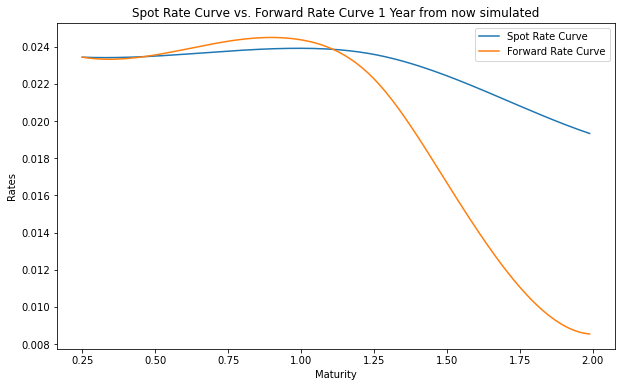

In [288]:
end = test.maturity - test.optMaturity

steps = np.arange (test.delta, end, 0.01)

pos = int(test.optMaturity/test.delta)
sub = test.optMaturity

plt.figure(figsize=(10,6))
plt.plot(steps, f_cubic(steps, test.maturity_array[pos:] - sub, sp_curve), label="Spot Rate Curve")
plt.plot(steps, f_cubic(steps, test.maturity_array[pos:] - sub, fwd_curve), label = "Forward Rate Curve")
plt.legend()
plt.title("Spot Rate Curve vs. Forward Rate Curve 1 Year from now simulated")
plt.xlabel("Maturity")
plt.ylabel("Rates")
plt.show()

# Example: Pricing of 5 Caplets 

In [269]:
strike_rates = [0.0500696, 0.0462954, 0.0454438, 0.04441244, 0.0426052]
mat_array = [1, 1.25, 1.5, 1.75, 2]
black_vol_array = [0.3192277, 0.2980176, 0.256390, 0.2435939, 0.221067]
date_start_array = [datetime.date(2023, 7, 28),  datetime.date(2023, 10, 28),  datetime.date(2024, 1, 28),  
               datetime.date(2024, 4, 28),  datetime.date(2024, 7, 28)]
date_end_array = [datetime.date(2023, 10, 28),  datetime.date(2024, 1, 28),  datetime.date(2024, 4, 28),  
               datetime.date(2024, 7, 28),  datetime.date(2024, 10, 28)]

In [270]:
test.val_date = datetime.date(2022, 10, 28)
test.notional = 1000000

In [271]:
price_lmm = []
range_lmm = []
vol_lmm = []
bs_array = []

for i in range(len(mat_array)):
    test.strike_k = strike_rates[i]
    test.opt_date = date_start_array[i]
    test.end_date = date_end_array[i]
    test.bs_vol = black_vol_array[i]
    
    price_caplet, range_caplet = test.f_caplet(mat_array[i])
    impl_vol_caplet = test.get_caplet_implied_vola(mat_array[i])
    bs_price = test.get_bs_cap_price(mat_array[i])
    
    price_lmm.append(price_caplet)
    range_lmm.append(range_caplet)
    vol_lmm.append(impl_vol_caplet)
    bs_array.append(bs_price)
    

In [275]:
result = pd.DataFrame({"Black Scholes Price": bs_array, "Implied Vol Mkt": black_vol_array, "Price LMM": price_lmm, 
              "CI_down": np.array(price_lmm) - np.array(range_lmm), "CI_up": np.array(price_lmm) + np.array(range_lmm),
              "Implied Vol LMM": vol_lmm, "Deviation Price": (np.array(bs_array) - np.array(price_lmm))/np.array(bs_array),
              "Deviation Vol": (np.array(black_vol_array) - np.array(vol_lmm))/np.array(black_vol_array)})
result

,Black Scholes Price,Implied Vol Mkt,Price LMM,CI_down,CI_up,Implied Vol LMM,Deviation Price,Deviation Vol
0,1242.158360,0.319228,1290.608227,1150.114566,1431.101889,0.311830,-0.039005,0.023175
1,1734.273679,0.298018,1606.239114,1455.108667,1757.369562,0.315811,0.073826,-0.059705
2,1680.515133,0.256390,1600.564710,1453.242813,1747.886608,0.282836,0.047575,-0.103148
3,1721.999758,0.243594,1505.401038,1368.895474,1641.906603,0.248506,0.125783,-0.020166
4,1770.141670,0.221067,1683.831117,1532.860690,1834.801545,0.272664,0.048759,-0.233399


The prices in the LIBOR Market Model are reasonable close to the market prices as well as volatilities (all within CI). RMSE is also rather small for a notional of USD 1 million. However, in theory the prices should be exactly the same, so some reasons why they could differ: 

1. the number of paths might have to increase to $n=100,000$ or above (now just 1.000 paths are simulated - too low)
2. there might be other assumptions in Reuters (e.g., other function type instead of a cubic function for interpolation)
3. there could be small approximation errors (e.g., for the minimization solution at step 4 in the calibration procedure) that add up in the bootstrap methodology

 One can also calculate other statistics like RMSE:
 
 $RMSE = \sqrt{\sum_{m=1}^{k} \frac{(P_{Black} - P_{LMM})^2}{k}}$ with $k$ as the number of options

In [289]:
rmse = np.sqrt(np.sum((np.array(result["Black Scholes Price"]) - np.array(result["Price LMM"]))**2)/len(result["Black Scholes Price"]))
rmse

126.09268541068265

### ... Continue with the multifactor LMM ...